In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib import cm
from highlight_text import fig_text,ax_text
from matplotlib.colors import LinearSegmentedColormap,Normalize
from matplotlib import cm
import matplotlib.gridspec as gridspec

from mplsoccer import VerticalPitch, Pitch

from PIL import Image
import urllib
import json
import os

In [29]:
from seleniumbase import Driver

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from webdriver_manager.chrome import ChromeDriverManager

import time

options = Options()
options.headless = True

# driver = webdriver.Chrome(options=options,service=ChromeService(ChromeDriverManager().install()))
driver = webdriver.Chrome(options=options,service=ChromeService(ChromeDriverManager(version='114.0.5735.90').install()))


In [30]:
plt.style.use('../../assets/stylesheets/soc_base.mplstyle')

In [31]:
colors = [
    '#efe9e6',
    '#e9e1dd',
    '#e3dad3',
    '#dcd3c9',
    '#d4ccc0',
    '#ccc6b7',
    '#c3bfae',
    '#bab9a6',
    '#b0b39e',
    '#a6ad96',
    '#9ba790',
    '#90a18a',
    '#849b84',
    '#789680',
    '#6c907c',
    '#608a79',
    '#538476',
    '#467e74',
    '#387872',
    '#287271',
]
soc_cm = LinearSegmentedColormap.from_list('SOC', colors, N=50)
cm.register_cmap(name='SOC', cmap=soc_cm)

In [56]:
def get_match_events(driver, whoscored_match_id=1640761):
    whoscored_match_url = f'https://www.whoscored.com/Matches/{whoscored_match_id}/Live/'
    driver.get(whoscored_match_url)
    scriptdiv = driver.find_elements(By.CSS_SELECTOR, 'script')
    # indicator_string = 'require.requconfig.params["args"]'
    indicator_string = 'matchCentreData'
    jstring = ''
    for i in range(len(scriptdiv)):
        jstring = scriptdiv[-1*(i+1)].get_attribute('innerHTML')
        if indicator_string in jstring:
            # print(i)
            # print(jstring)
            break
    jstring = jstring.replace('require.config.params["args"] = ', '')
    jstring = jstring.replace('\n', '')
    jstring = jstring.replace('            ', '')
    jstring = jstring.replace('{matchId:', '{"matchId":')
    jstring = jstring.replace('matchCentreData:', '"matchCentreData":')
    jstring = jstring.replace(
        'formationIdNameMappings', '"formationIdNameMappings"')
    jstring = jstring.replace(
        'matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    jstring = jstring.replace('};', '}')    
    
    d = json.loads(jstring)
    print(d)
    matchData = d['matchCentreData']
    matchId = d['matchId']
    events = matchData['events']
    player_dict = d['matchCentreData']['playerIdNameDictionary']
    players = {
        'id': player_dict.keys(),
        'name': player_dict.values()
    }
    players_df = pd.DataFrame(players).reset_index()
    players_df['id'] = players_df['id'].astype(int)
    event_list = []
    for e in enumerate(events):
        ev = e[1]
        try:
            player_id = ev['playerId']
        except:
            player_id = None
        try:
            player_name = players_df[players_df['id']
                                     == player_id]['name'].iloc[0]
            # print(f'{player_id} : {player_name}')
        except:
            player_name = None
        try:
            endX = ev['endX']
        except:
            endX = None
        try:
            endY = ev['endY']
        except:
            endY = None

        event_list.append({
            'id': ev['id'],
            'eventId': ev['eventId'],
            'minute': ev['minute'],
            'teamId': ev['teamId'],
            'playerId': player_id,
            'playerName': player_name,
            'matchId': matchId,
            'x': ev['x'],
            'y': ev['y'],
            'endX': endX,
            'endY': endY,
            'expandedMinute': ev['expandedMinute'],
            'period': ev['period']['displayName'],
            'type': ev['type']['displayName'],
            'outcomeType': ev['outcomeType']['displayName'],
            'isTouch': ev['isTouch']
        })
    event_df = pd.DataFrame(event_list)
    return event_df


In [57]:
def draw_heatmap(fig,ax,data,player_id):
    touches = data[data['isTouch']==True]
    touches_success = data[(data['isTouch']==True)&(data['outcomeType']=='Successful')]
    player_touches = touches[touches['playerId']==player_id]
    player_touches_success = touches_success[touches_success['playerId']==player_id]
    
    pitch = VerticalPitch(
        pitch_type='opta',
        goal_type='box',
        linewidth=1.25,
        line_color='black'
    )
    pitch.draw(ax=ax)

    pitch.kdeplot(
        player_touches['x'], player_touches['y'],
        ax=ax, fill=True,
        levels=100, shade_lowest=True,
        cut=4, zorder=-1, cmap='SOC'
    )
    ax.scatter(player_touches['y'], player_touches['x'],
            s=20, alpha=.2, lw=1.5, color='#287271')

    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1])
    ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1])

    DC_to_FC = ax.transData.transform
    FC_to_NFC = fig.transFigure.inverted().transform
    def DC_to_NFC(x): return FC_to_NFC(DC_to_FC(x))

    player_name = player_touches['playerName'].unique()[0]
    team_id = player_touches['teamId'].unique()[0]

    total_touches = len(player_touches)
    total_touches_success = len(player_touches_success)
    final_third = player_touches[player_touches['y']
                                >= (100*2)/3].shape[0]/total_touches

    ax_text(
        x=95, y=115,
        s=f'{player_name}\n<touches {total_touches_success:.0f}/{total_touches:.0f} | final third {final_third:.0%}>',
        highlight_textprops=[{'size': 7, 'weight': 'normal'}],
        ax=ax, weight='bold', size=10, font='DM Sans', ha='left'
    )

    ax_coords = DC_to_NFC((15, 105))
    ax_size = .04

    image_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], ax_size, ax_size],
        fc='None', anchor='S'
    )
    
    hdr = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
       'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
       'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
       'Accept-Encoding': 'none',
       'Accept-Language': 'en-US,en;q=0.8',
       'Connection': 'keep-alive'}

    fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
    whoscored_url = 'https://d2zywfiolv4f83.cloudfront.net/img/teams/'
    player_face_url = 'https://d2zywfiolv4f83.cloudfront.net/img/players/'
    # player_face = Image.open(urllib.request.urlopen(f"{fotmob_url}{fotmob_team_id}.png"))
    # print(f"{player_face_url}{int(player_id)}.jpg")
    # player_face = Image.open(urllib.request.urlopen(f"{player_face_url}{player_id}.jpg"))
    club_logo = Image.open(urllib.request.urlopen(f"{whoscored_url}{team_id}.png"))
    image_ax.imshow(club_logo)
    image_ax.axis("off")
    
    print(f"Draw heatmap {player_name}")


{'matchId': 1746064, 'matchCentreData': {'playerIdNameDictionary': {'423450': 'Kristjan Asllani', '299344': 'Lautaro Martínez', '28421': 'Henrikh Mkhitaryan', '34693': 'Marko Arnautovic', '357897': 'Carlos Augusto', '44868': 'Juan Cuadrado', '470973': 'Issiaka Kamate', '388505': 'Lucien Agoumé', '259648': 'Benjamin Pavard', '296322': 'Marcus Thuram', '349126': 'Yann Bisseck', '331425': 'Davide Frattesi', '255929': 'Federico Dimarco', '148684': 'Nicolò Barella', '329665': 'Alessandro Bastoni', '23220': 'Matteo Darmian', '254692': 'Emil Audero', '494515': 'Alessandro Calligaris', '108860': 'Davy Klaassen', '82399': 'Stefan de Vrij', '322153': 'Denzel Dumfries', '497393': 'Amadou Sarr', '35758': 'Yann Sommer', '110373': 'Hakan Çalhanoglu', '343368': "M'Bala Nzola", '329854': 'Lucas Martínez', '405119': 'Gino Infantino', '345322': 'Nicolás González', '365410': 'Lucas Beltrán', '284114': 'Arthur', '318432': 'Yerry Mina', '298792': 'Josip Brekalo', '403641': 'Oliver Christensen', '113762': '

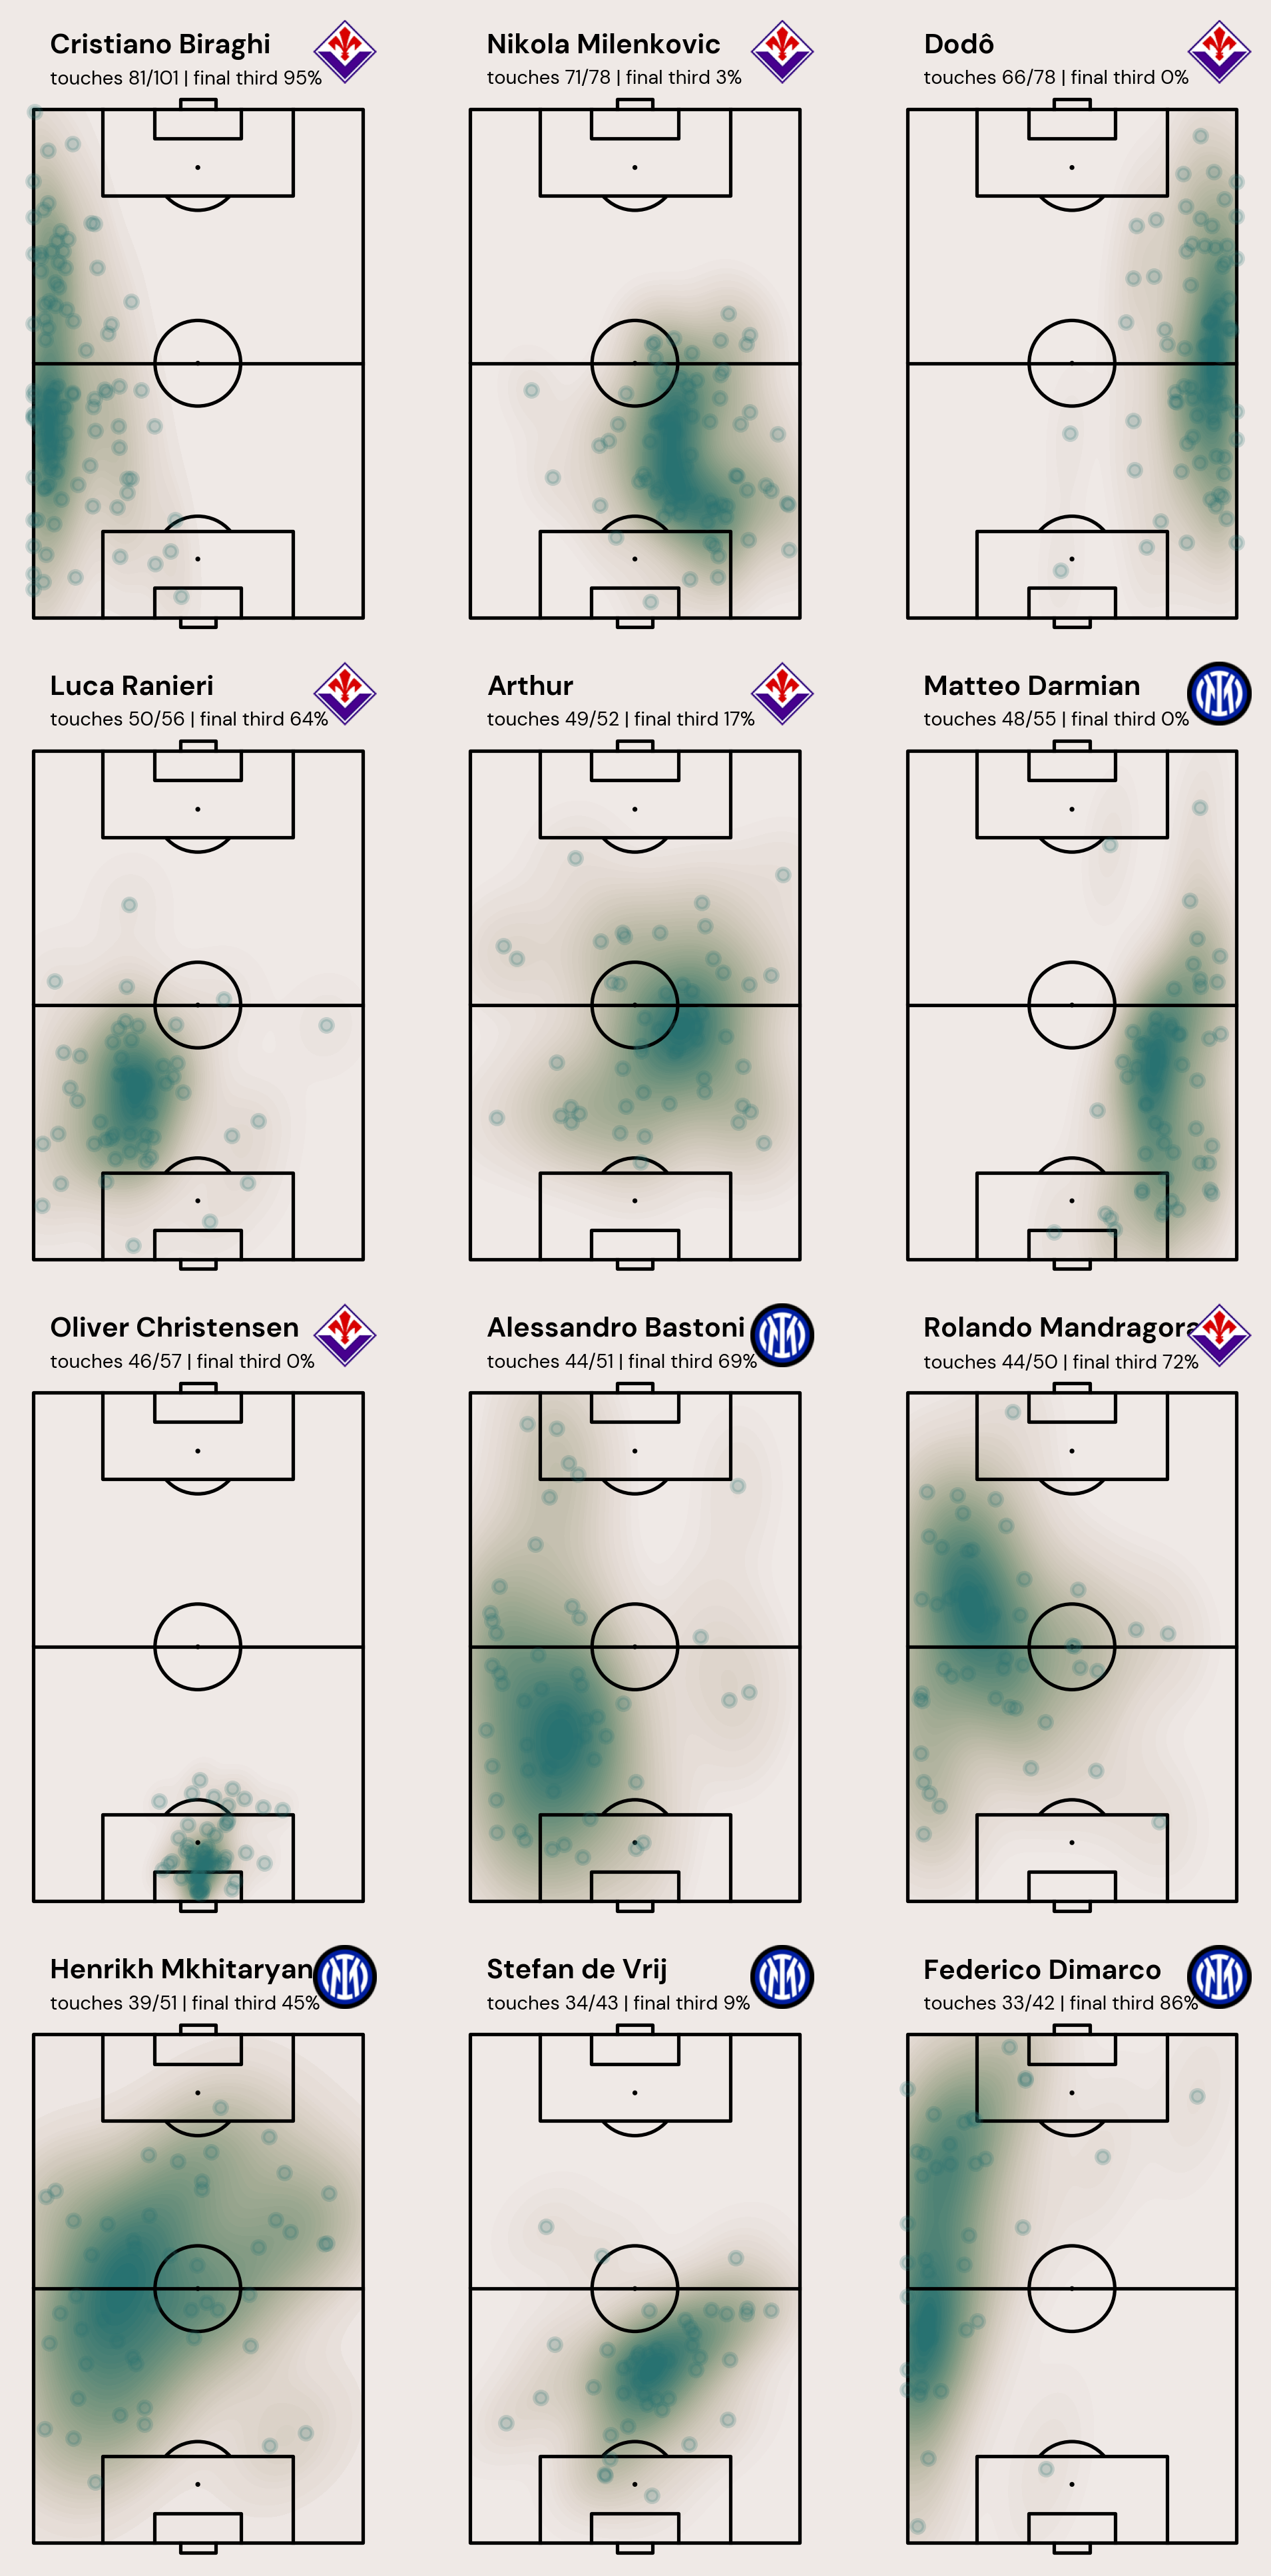

In [64]:
fig = plt.figure(figsize=(8, 16), dpi=300)
layout_ = '''
    ABC
    DEF
    GHI
    JKL
'''
axs = fig.subplot_mosaic(layout_)

# data = pd.read_csv('../../data/man_derby_touches.csv')
driver = Driver(browser="chrome")
data = get_match_events(driver,1746064)
driver.quit()
most_touches = data[(data['isTouch']==True)&(data['outcomeType']=='Successful')].groupby(['playerId','playerName'])['id'].count().reset_index(name='count').sort_values('count',ascending=False)[:12]

for i in range(len(most_touches)):
    player_id = most_touches['playerId'].iloc[i]    
    ax = axs[list(axs.keys())[i]]
    draw_heatmap(fig,ax,data,player_id)
